In [73]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_prediction_subplot

In [74]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\3940554349.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [75]:
# Manually select 11 test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2320, 2478, 2769, 3127, 3141]
#703, 2085
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# GlacierID has no_annual/no_winter/no_summer points Location
# 54 has 189/174/172 points Finnmark (Langfjordjøkelen)
# 703 has 30/30/31 points Narvik
#NOT USED# 675 has 178 points Narvik
# 941 has 70/71/70 points Blåmannsisen (Bodø)
# 1135 has 56/29/29 points Svartisen sør
# 1280 has 71/57/72 points Breiaren (nær Svartisen)
# 2320 has 83/83/84 points Jostedalsbreen
# 2085 has 163/157/157 points Ålfotbreen
# 2478 has 89/89/89 points Jostedalsbreen
# 2769 has 121/116/116 points Jotunheimen
# 3127 has 145/144/157 points Folgefonna
# 3141 has 72/70/70 points Folgefonna
# Test dataset has 1089/1020/1047 points in total, approximately 27% of the data
# Train dataset has 2821/2732/2882 points, approximately 73% of the data

df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2984/926
Train/test winter: 2889/863
Train/test summer: 3039/890
All train/test: 8912 / 2679
Fraction train/test: 0.7688724010007765 / 0.23112759899922353
Total entries: 11591


### Distribution of training and test datasets

Train mass balance: median -0.07, min -13.1, max 5.72.
Test mass balance: median -0.72, min -6.3, max 4.1.
Train altitude: mean 1331.683880697051, min 190.0, max 2212.0.
Test altitude: mean 1266.8606911447084, min 390.0, max 2105.0.
Train mean temp: mean -1.6094610536385971, min -7.492487335205055, max 3.914905802408896.
Test mean temp: mean -1.9553580834078161, min -7.176125590006507, max 2.0174296061198334.
Train prec sum: mean 0.06827432874074502, min 0.026136178523301197, max 0.132155250757932.
Test prec sum: mean 0.057889794236849035, min 0.026136178523301197, max 0.12064879294484779.


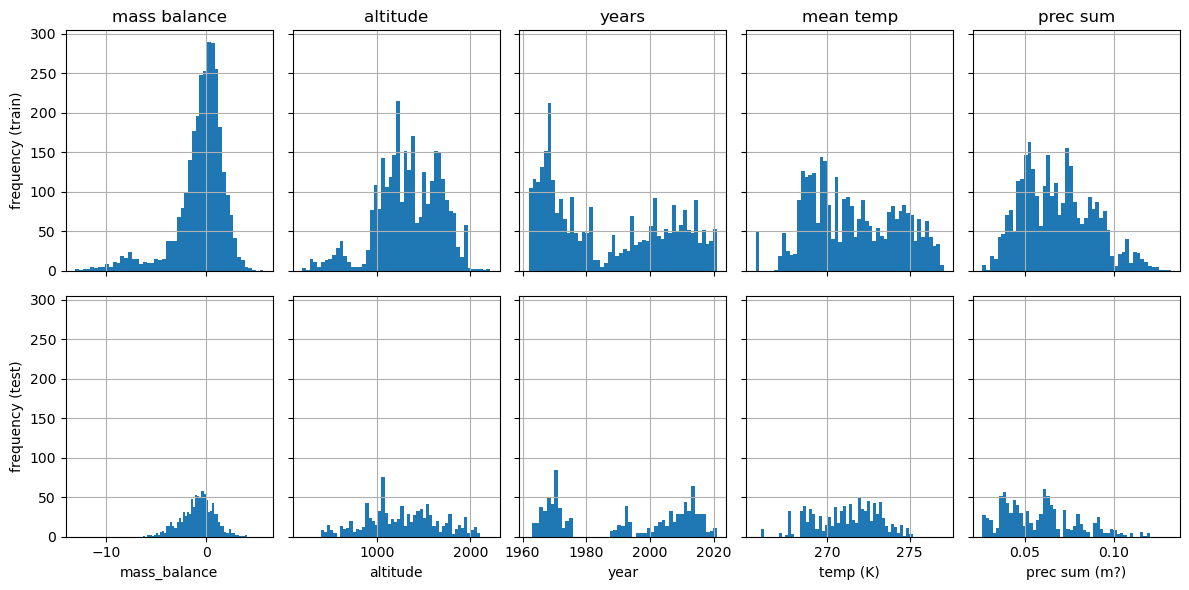

In [76]:
# Number of measurements by topography
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']

f, ax = plt.subplots(2, 5, figsize=(12,6), sharey=True, sharex='col')
df_train_annual['balance_netto'].plot.hist(bins=50, ax=ax[0,0])
ax[0,0].set_title('mass balance')
ax[0,0].set_ylabel('frequency (train)')
df_train_annual['altitude'].plot.hist(bins=50, ax=ax[0,1])
ax[0,1].set_title('altitude')
df_train_annual['year'].plot.hist(bins=50, ax=ax[0,2])
ax[0,2].set_title('years')
df_train_annual[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[0,3])
ax[0,3].set_title('mean temp')
df_train_annual[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[0,4])
ax[0,4].set_title('prec sum')

df_test_annual['balance_netto'].plot.hist(bins=50, ax=ax[1,0])
ax[1,0].set_ylabel('frequency (test)')
ax[1,0].set_xlabel('mass_balance')
df_test_annual['altitude'].plot.hist(bins=50, ax=ax[1,1])
ax[1,1].set_xlabel('altitude')
df_test_annual['year'].plot.hist(bins=50, ax=ax[1,2])
ax[1,2].set_xlabel('year')
df_test_annual[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[1,3])
ax[1,3].set_xlabel('temp (K)')
df_test_annual[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[1,4])
ax[1,4].set_xlabel('prec sum (m?)')

for row in ax:
    for a in row:
        a.grid()

plt.tight_layout()

T_0 = 273.15
print(f"Train mass balance: median {df_train_annual['balance_netto'].median()}, min {df_train_annual['balance_netto'].min()}, max {df_train_annual['balance_netto'].max()}.")
print(f"Test mass balance: median {df_test_annual['balance_netto'].median()}, min {df_test_annual['balance_netto'].min()}, max {df_test_annual['balance_netto'].max()}.")
print(f"Train altitude: mean {df_train_annual['altitude'].mean()}, min {df_train_annual['altitude'].min()}, max {df_train_annual['altitude'].max()}.")
print(f"Test altitude: mean {df_test_annual['altitude'].mean()}, min {df_test_annual['altitude'].min()}, max {df_test_annual['altitude'].max()}.")
print(f"Train mean temp: mean {df_train_annual[temp_cols].mean().mean()-T_0}, min {df_train_annual[temp_cols].mean(axis=1).min()-T_0}, max {df_train_annual[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Test mean temp: mean {df_test_annual[temp_cols].mean().mean()-T_0}, min {df_test_annual[temp_cols].mean(axis=1).min()-T_0}, max {df_test_annual[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Train prec sum: mean {df_train_annual[prec_cols].sum(axis=1).mean()}, min {df_train_annual[prec_cols].sum(axis=1).min()}, max {df_train_annual[prec_cols].sum(axis=1).max()}.")
print(f"Test prec sum: mean {df_test_annual[prec_cols].sum(axis=1).mean()}, min {df_test_annual[prec_cols].sum(axis=1).min()}, max {df_test_annual[prec_cols].sum(axis=1).max()}.")

In [77]:
# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6

C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\1628288660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\1628288660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\1628288660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [78]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
#sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, dewpt_temp, surface_pressure, 
                         sol_rad_down, sol_therm_down, u_wind, v_wind, f_albedo] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

In [79]:
df_train_annual_clean.columns


Index(['BREID', 'altitude', 'balance', 'aspect', 'slope', 't2m_oct', 't2m_nov',
       't2m_dec', 't2m_jan', 't2m_feb', 't2m_mar', 't2m_apr', 't2m_may',
       't2m_jun', 't2m_jul', 't2m_aug', 't2m_sep', 'slhf_oct', 'slhf_nov',
       'slhf_dec', 'slhf_jan', 'slhf_feb', 'slhf_mar', 'slhf_apr', 'slhf_may',
       'slhf_jun', 'slhf_jul', 'slhf_aug', 'slhf_sep', 'ssr_oct', 'ssr_nov',
       'ssr_dec', 'ssr_jan', 'ssr_feb', 'ssr_mar', 'ssr_apr', 'ssr_may',
       'ssr_jun', 'ssr_jul', 'ssr_aug', 'ssr_sep', 'str_oct', 'str_nov',
       'str_dec', 'str_jan', 'str_feb', 'str_mar', 'str_apr', 'str_may',
       'str_jun', 'str_jul', 'str_aug', 'str_sep', 'sshf_oct', 'sshf_nov',
       'sshf_dec', 'sshf_jan', 'sshf_feb', 'sshf_mar', 'sshf_apr', 'sshf_may',
       'sshf_jun', 'sshf_jul', 'sshf_aug', 'sshf_sep', 'tp_oct', 'tp_nov',
       'tp_dec', 'tp_jan', 'tp_feb', 'tp_mar', 'tp_apr', 'tp_may', 'tp_jun',
       'tp_jul', 'tp_aug', 'tp_sep', 'altitude_climate', 'n_months'],
      dtype='object')

In [80]:
# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)

#var = ['u10', 'v10', 't2m', 'fal', 'sshf', 'slhf', 'ssr', 'str', 'tp']
var = ['t2m', 'sshf', 'slhf', 'ssr', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

In [81]:
# Combine the three dataframes
#df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])
df_train_all = df_train_annual_clean.copy()

In [29]:
df_train_all

,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
189,596,990.0,-1.76,2.509464,0.238202,269.201416,264.435547,258.228821,258.308533,257.074158,...,0.005483,0.003681,0.002447,0.003016,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943
190,596,996.0,-0.30,2.474161,0.117946,269.387421,261.827911,262.573364,265.326019,260.279266,...,0.012715,0.002994,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943
191,596,988.0,-2.18,2.509464,0.238202,270.417572,259.927002,254.755005,255.577148,252.211121,...,0.001472,0.000642,0.003090,0.001900,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943
192,596,990.0,-1.68,2.478294,0.146882,267.011292,265.178741,258.606110,257.204742,261.810455,...,0.003862,0.002945,0.003645,0.003376,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943
193,596,990.0,-0.31,2.478294,0.146882,267.775757,267.829651,256.208740,254.525742,259.089691,...,0.001893,0.004887,0.004874,0.004694,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,3138,1151.4,-2.48,3.229342,0.093474,274.722626,268.512878,271.717194,268.662445,268.665466,...,0.007993,0.006946,0.009393,0.007489,0.003727,0.008407,0.008133,0.007797,0.006275,903.493549
3834,3138,1196.0,-1.22,3.752693,0.116894,274.083435,267.734009,270.984650,268.008057,267.870636,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689
3835,3138,1399.5,0.84,3.996078,0.040634,274.083435,267.734009,270.984650,268.008057,267.870636,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689
3836,3138,1513.3,1.44,3.214424,0.043804,274.083435,267.734009,270.984650,268.008057,267.870636,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689


In [82]:
# Get mean values of meteorological variables
var_mean = ['t2m']
var_sum = ['sshf', 'slhf', 'ssr', 'str', 'tp']

spring = ['mar', 'apr', 'may']
summer = ['jun','jul','aug']
winter = ['dec','jan','feb']
fall = ['sep','oct','nov']

for name in var_sum:
    df_train_all[name+'_sp']= df_train_all[[name + '_' + e for e in spring]].sum(axis=1)
    df_train_all[name+'_su']= df_train_all[[name + '_' + e for e in summer]].sum(axis=1)
    df_train_all[name+'_wi']= df_train_all[[name + '_' + e for e in winter]].sum(axis=1)
    df_train_all[name+'_fa']= df_train_all[[name + '_' + e for e in fall]].sum(axis=1)

for name in var_mean:
    df_train_all[name+'_sp']= df_train_all[[name + '_' + e for e in spring]].mean(axis=1)
    df_train_all[name+'_su']= df_train_all[[name + '_' + e for e in summer]].mean(axis=1)
    df_train_all[name+'_wi']= df_train_all[[name + '_' + e for e in winter]].mean(axis=1)
    df_train_all[name+'_fa']= df_train_all[[name + '_' + e for e in fall]].mean(axis=1)

In [83]:
df_train_all = df_train_all[['BREID','altitude','altitude_climate','balance','aspect','slope','t2m_sp','t2m_su','t2m_wi','t2m_fa','tp_sp','tp_su','tp_wi','tp_fa','sshf_sp','sshf_su','sshf_wi','sshf_fa', 'slhf_sp','slhf_su','slhf_wi','slhf_fa',
                             'ssr_sp','ssr_su','ssr_wi','ssr_fa','str_sp','str_su','str_wi','str_fa']]

In [32]:
df_train_all.columns

Index(['BREID', 'altitude', 'altitude_climate', 'balance', 'aspect', 'slope',
       't2m_sp', 't2m_su', 't2m_wi', 't2m_fa', 'tp_sp', 'tp_su', 'tp_wi',
       'tp_fa', 'sshf_sp', 'sshf_su', 'sshf_wi', 'sshf_fa', 'slhf_sp',
       'slhf_su', 'slhf_wi', 'slhf_fa', 'ssr_sp', 'ssr_su', 'ssr_wi', 'ssr_fa',
       'str_sp', 'str_su', 'str_wi', 'str_fa'],
      dtype='object')

In [33]:
df_train_all

,BREID,altitude,altitude_climate,balance,aspect,slope,t2m_sp,t2m_su,t2m_wi,t2m_fa,...,slhf_wi,slhf_fa,ssr_sp,ssr_su,ssr_wi,ssr_fa,str_sp,str_su,str_wi,str_fa
189,596,990.0,1001.181943,-1.76,2.509464,0.238202,267.013072,277.883698,257.870504,270.075185,...,265475.5,-1253085.0,10960882.5,29298571.0,242931.0,5239017.5,-7102371.75,-9890561.50,-3277967.75,-3853175.00
190,596,996.0,1001.181943,-0.30,2.474161,0.117946,267.571289,276.443858,262.726217,267.881541,...,79612.5,-752940.0,9241912.5,23622279.0,262517.0,3881995.0,-7478645.00,-6759956.25,-2685191.75,-3987140.00
191,596,988.0,1001.181943,-2.18,2.509464,0.238202,263.718414,278.554779,254.181091,267.008769,...,175352.5,-689880.0,9441529.5,30379519.0,432003.0,3556581.0,-7949901.00,-9211586.75,-3599154.00,-3652959.50
192,596,990.0,1001.181943,-1.68,2.478294,0.146882,267.712240,277.595988,259.207102,269.933990,...,286410.5,-1222959.0,9485220.5,22170721.0,282101.0,4547135.5,-8074898.25,-6179808.00,-3786192.50,-3764048.00
193,596,990.0,1001.181943,-0.31,2.478294,0.146882,266.347575,276.279897,256.608058,269.911723,...,230243.0,-1142537.0,7742521.5,18811121.5,274192.0,6383240.0,-7239265.25,-4040396.50,-3191952.25,-5589960.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,3138,1151.4,903.493549,-2.48,3.229342,0.093474,273.212962,281.172282,269.681702,274.452891,...,-172374.5,-1517071.0,10478033.5,15245878.5,1361166.0,5636746.0,-5779377.50,-1381047.00,-3775943.75,-4999928.75
3834,3138,1196.0,1046.032689,-1.22,3.752693,0.116894,272.415365,280.293213,268.954447,273.713745,...,-31956.0,-349812.0,6934636.0,9662992.0,876058.0,3855630.0,-5011641.50,730180.50,-3065673.75,-3820965.00
3835,3138,1399.5,1046.032689,0.84,3.996078,0.040634,272.415365,280.293213,268.954447,273.713745,...,-31956.0,-349812.0,6934636.0,9662992.0,876058.0,3855630.0,-5011641.50,730180.50,-3065673.75,-3820965.00
3836,3138,1513.3,1046.032689,1.44,3.214424,0.043804,272.415365,280.293213,268.954447,273.713745,...,-31956.0,-349812.0,6934636.0,9662992.0,876058.0,3855630.0,-5011641.50,730180.50,-3065673.75,-3820965.00


In [84]:
# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [85]:
# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [86]:
print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2085 2148 2474 2514 2597 2743 2768 2772
 2968 3126 3128 3129 3133 3137 3138]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2085 2148 2297 2474 2514 2597 2743 2768 2772
 2968 3126 3128 3129 3133 3137 3138]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2085 2297 2514 2597 2743 2768 2772 2968 3128
 3129 3133]
Validation, fold 2:  [1094 2148 2474 3126 3137 3138]
Train, fold 3:  [ 596 1094 2078 2085 2148 2297 2474 2597 2768 2968 3126 3129 3133 3137
 3138]
Validation, fold 3:  [ 675 1092 1144 2514 2743 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2148 2297 2474 2514 2743 2772 3126 3128 3137
 3138]
Validation, fold 4:  [ 596 2085 2597 2768 2968 3129 3133]


In [37]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.740698484779945
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-1.60236225 -1.57371056 -1.87410864 -1.79457387 -1.8587371 ]
Mean cross validation score:  -1.740698484779945
Standard deviation:  0.12779344323489236


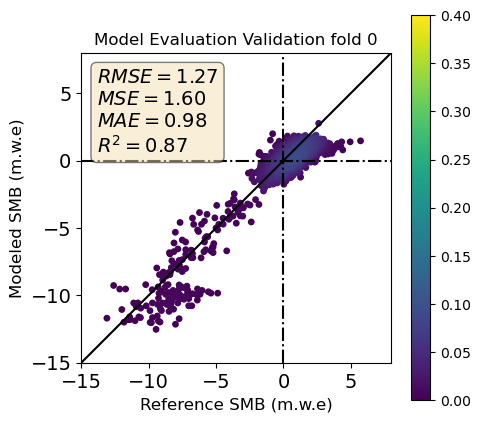

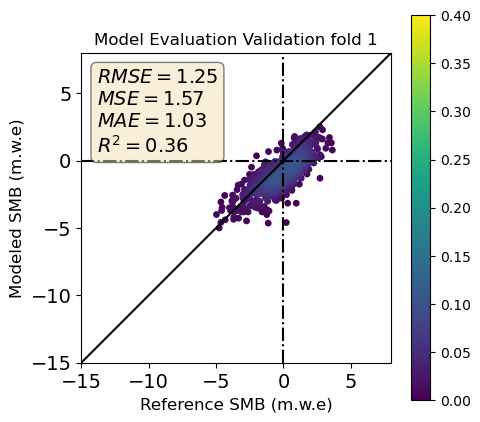

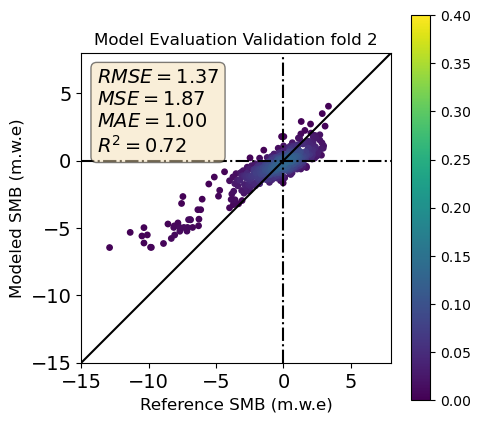

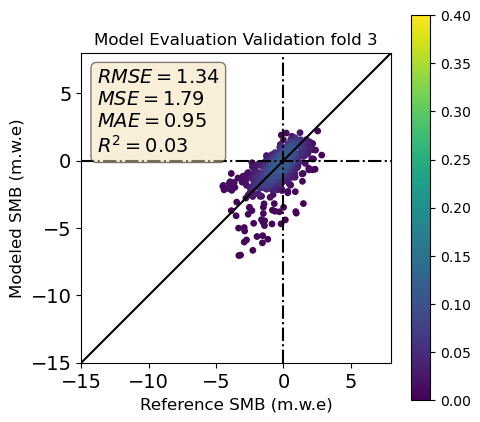

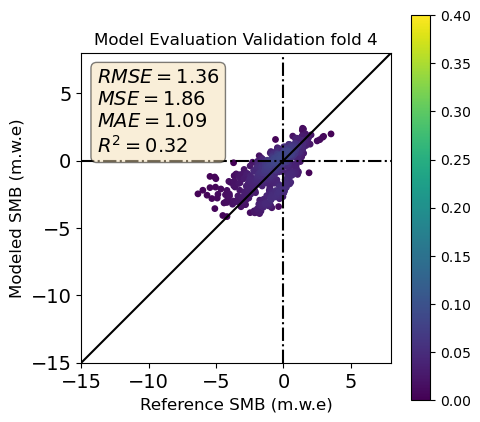

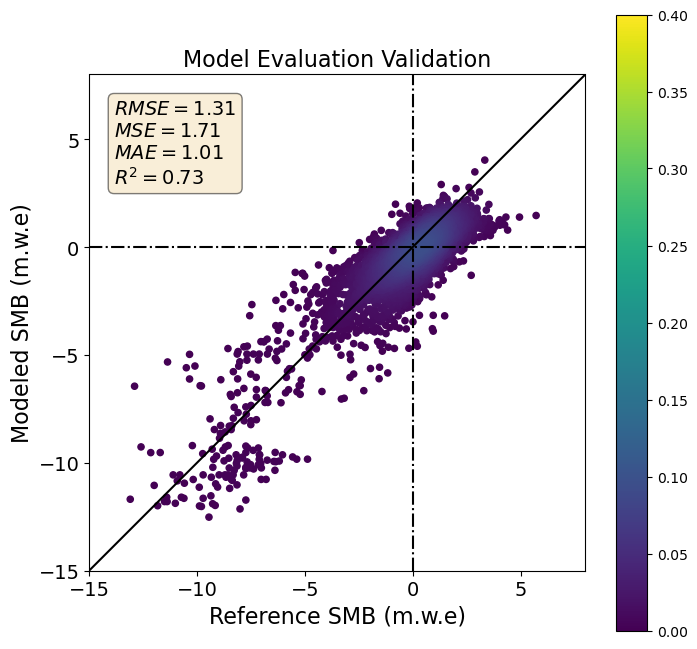

In [38]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [87]:
#joblib.dump(cv_grid, 'Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_mean_climate_ann_only.pkl')
cv_grid = joblib.load('Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_mean_climate_ann_only.pkl')
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [40]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\2583338049.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


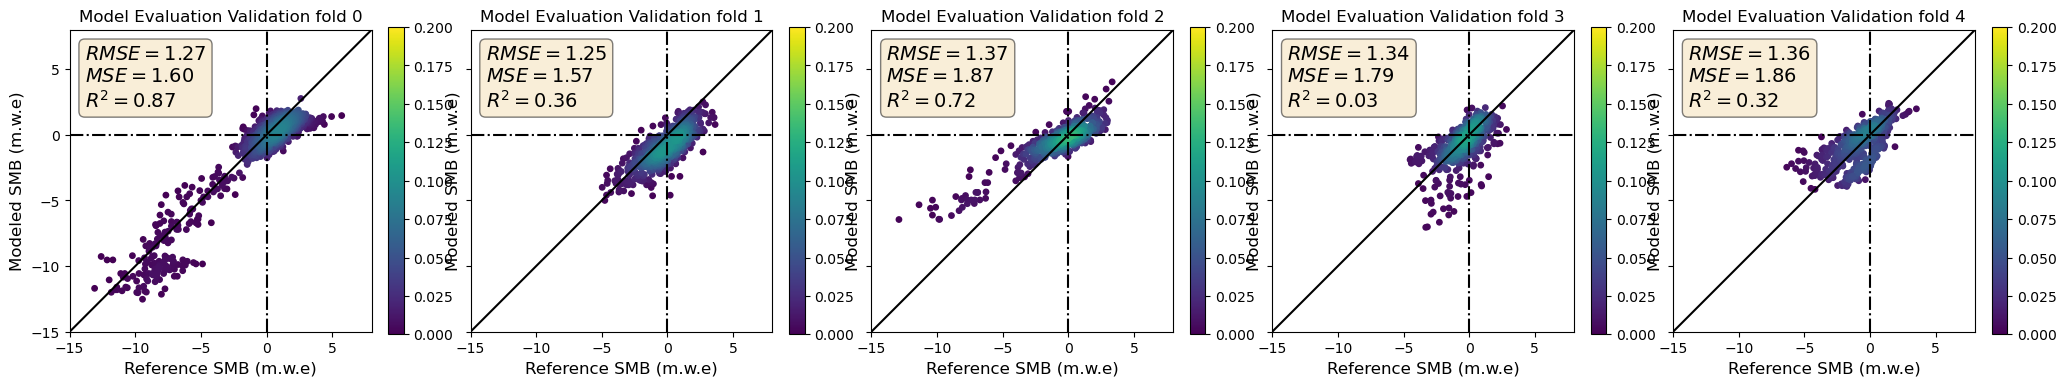

In [41]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    #indices = np.argwhere((X_test == 6))[:,0]
    #y_test_crop = y_test[indices]
    #y_pred_crop = y_pred[indices]

    #plot_prediction_subplot(y_test_crop, y_pred_crop, title, ax[a], n_toplot=5000, fold=True)
    plot_prediction_subplot(y_test, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\1656088105.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


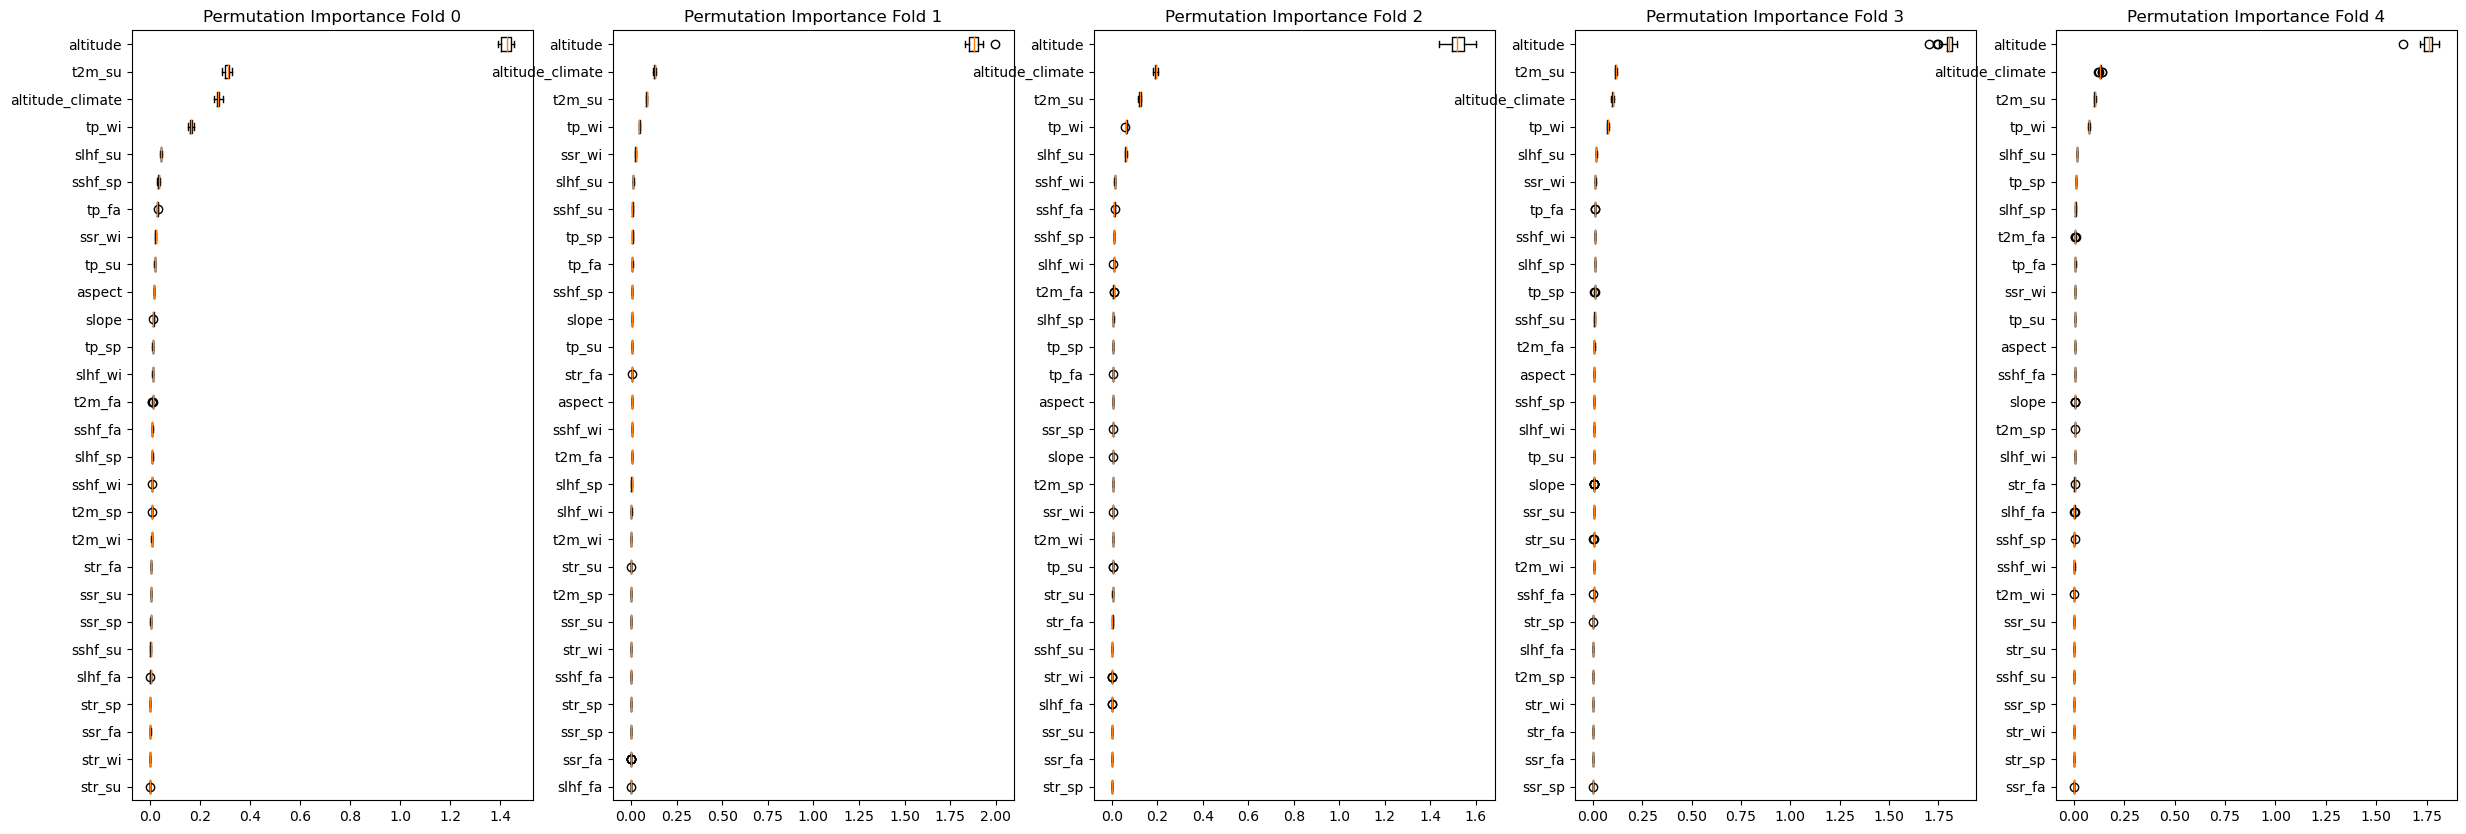

In [43]:
# Plot permutation importance

max_features_plot = 28

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]

    best_model.fit(X_train, y_train)
    
    result = permutation_importance(best_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

    sorted_idx = result.importances_mean.argsort()
    labels = np.array(df_train_X_s.columns)[sorted_idx][-max_features_plot:]
    
    ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
    ax[a].set_title("Permutation Importance Fold " + str(a))

    a=a+1

fig.show()

In [49]:
# Add month column
#X_train_w_months = np.hstack((X_train_s, np.ones((2984,1))*12))


In [58]:
# Plot residuals vs elevation and location

type = 'annual'

lon_list = []
lat_list = []
alt_list = []
breid_list = []
y_pred_list = []
y_test_list = []
i=0

if type=='annual':
    months=12
elif type=='winter':
    months=8
elif type=='summer':
    months=6
else:
    months=12

for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    #X_train_ign, X_test = X_train_s[train_index], X_train_s[test_index]
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    df_features_test = df_train_s.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #indices = np.argwhere((X_test == months))[:,0]
    #y_test_crop = y_test[indices]
    #y_pred_crop = y_pred[indices]
    #df_features_test_crop = df_features_test.iloc[indices]
    
    #X_lat = df_features_test['lat'].values
    #X_lon = df_features_test['lon'].values
    X_alt = df_features_test['altitude'].values
    #X_breid = df_features_test['BREID'].values

    y_test_list.extend(y_test)
    y_pred_list.extend(y_pred)
    
    #lat_list.extend(X_lat.tolist())
    #lon_list.extend(X_lon.tolist())
    alt_list.extend(X_alt.tolist())
    #breid_list.extend(X_breid.tolist())

    i=i+1
        
# Arrays of predictions and observations for each fold
#lat_all = np.hstack([*lat_list])
#lon_all = np.hstack([*lon_list])
alt_all = np.hstack([*alt_list])
#breid_all = np.hstack([*breid_list])
y_test_all = np.hstack([*y_test_list])
y_pred_all = np.hstack([*y_pred_list])
residuals_cropped = y_test_all - y_pred_all

In [60]:
mask_alt = alt_all >=850

In [64]:
alt_masked = alt_all[mask_alt]
y_pred_masked = y_pred_all[mask_alt]
y_test_masked = y_test_all[mask_alt]

In [67]:
# Approx 200 points below 850 masl are removed
print(alt_masked.shape)
print(alt_all.shape)

(2785,)
(2984,)


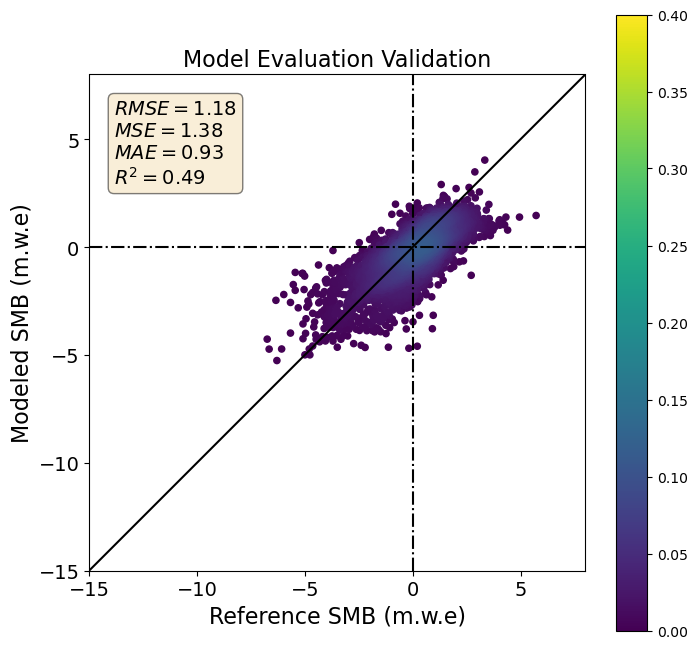

In [72]:
plot_prediction(y_test_masked, y_pred_masked, data_type='Validation')

C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\2997029204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\2997029204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_11712\2997029204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

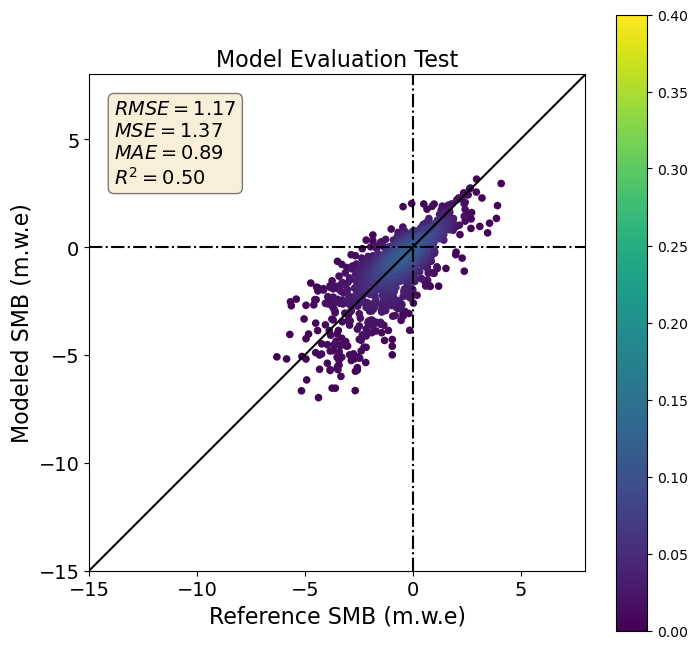

In [88]:
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

df_test_all = df_test_annual_clean.copy()

# Get mean values of meteorological variables
var_mean = ['t2m']
var_sum = ['sshf', 'slhf', 'ssr', 'str', 'tp']

spring = ['mar', 'apr', 'may']
summer = ['jun','jul','aug']
winter = ['dec','jan','feb']
fall = ['sep','oct','nov']

for name in var_sum:
    df_test_all[name+'_sp']= df_test_all[[name + '_' + e for e in spring]].sum(axis=1)
    df_test_all[name+'_su']= df_test_all[[name + '_' + e for e in summer]].sum(axis=1)
    df_test_all[name+'_wi']= df_test_all[[name + '_' + e for e in winter]].sum(axis=1)
    df_test_all[name+'_fa']= df_test_all[[name + '_' + e for e in fall]].sum(axis=1)

for name in var_mean:
    df_test_all[name+'_sp']= df_test_all[[name + '_' + e for e in spring]].mean(axis=1)
    df_test_all[name+'_su']= df_test_all[[name + '_' + e for e in summer]].mean(axis=1)
    df_test_all[name+'_wi']= df_test_all[[name + '_' + e for e in winter]].mean(axis=1)
    df_test_all[name+'_fa']= df_test_all[[name + '_' + e for e in fall]].mean(axis=1)


df_test_all = df_test_all[['BREID','altitude','altitude_climate','balance','aspect','slope','t2m_sp','t2m_su','t2m_wi','t2m_fa','tp_sp','tp_su','tp_wi','tp_fa','sshf_sp','sshf_su','sshf_wi','sshf_fa', 'slhf_sp','slhf_su','slhf_wi','slhf_fa',
                             'ssr_sp','ssr_su','ssr_wi','ssr_fa','str_sp','str_su','str_wi','str_fa']]

# Select features for training
df_test_X = df_test_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_all[['balance']]

X_test, y_test = df_test_X.values, df_test_y.values

test_model = xgb.XGBRegressor(**cv_grid.best_params_)
test_model.fit(X_train_s, y_train_s)
y_pred_test = test_model.predict(X_test)
plot_prediction(y_test, y_pred_test, data_type='Test')

